In [ ]:
!pip install tensorflow-addons

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import *
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 4
SHAPE = (256, 256, 3)

# 1.DATA

### Loading the Dataset

In [ ]:
!tar -zxvf {'VanGogh2Photo.tar.gz'}

In [ ]:
def load_img(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (256, 256))
    return (img-127.5)/127.5

In [ ]:
photo_list = tf.data.Dataset.list_files('Dataset/Photo/*.jpg')
style_list = tf.data.Dataset.list_files('Dataset/Style/*.jpg')

In [ ]:
photo_ds = photo_list.map(load_img)
style_ds = style_list.map(load_img)

dataset = tf.data.Dataset.zip((photo_ds, style_ds)).cache().shuffle(10000).batch(BATCH_SIZE)

In [ ]:
len(dataset)

1550

In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

### Testing the Dataset

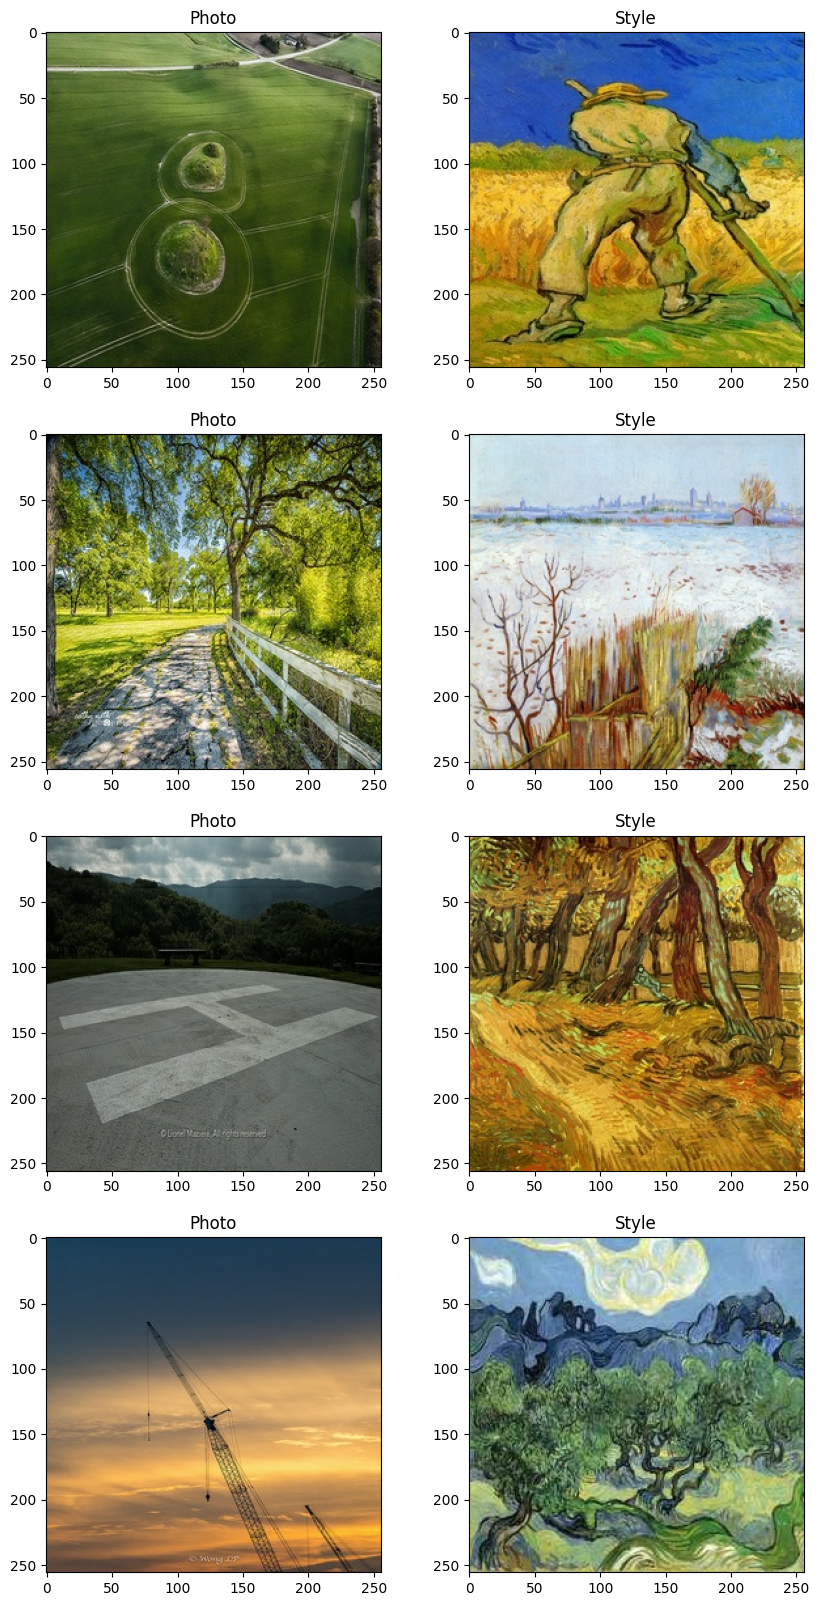

In [ ]:
sample = dataset.as_numpy_iterator().next()

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10,20))
for i in range(BATCH_SIZE):
    axes[i][0].imshow(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8))
    axes[i][0].set_title('Photo')
    axes[i][1].imshow(tf.cast(sample[1][i]*127.5+127.5, dtype=tf.uint8))
    axes[i][1].set_title('Style')

# MODEL

### Building the Model

In [ ]:
class CycleGAN(Model):
    def __init__(self):
        super(CycleGAN, self).__init__()

        self.generatorP = self.build_generator()            # Generates Photo from Style
        self.discriminatorP = self.build_discriminator()

        self.generatorS = self.build_generator()            # Generates Style from Photo
        self.discriminatorS = self.build_discriminator()


    # Builds a Generator
    def build_generator(self):
        def ConvBlock(filters, kernel, strides, x):
            x = Conv2D(filters, kernel, strides, 'same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(x)
            if filters==3:
                return Activation('tanh')(x)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            return ReLU()(x)

        # Defines Residual Block
        def ResBlock(filters, inputs):
            x = Conv2D(filters, 3, 1, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(inputs)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            x = ReLU()(x)

            x = Conv2D(filters, 3, 1, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(x)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            return Add()([x, inputs])

        def TransBlock(filters, x):
            x = Conv2DTranspose(filters, 3, 2, 'same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(x)
            x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            return ReLU()(x)

        input = Input(SHAPE)

        x = ConvBlock(64, 7, 1, input)
        x = ConvBlock(128, 3, 2, x)
        x = ConvBlock(256, 3, 2, x)

        for _ in range(9):
            x = ResBlock(256, x)

        x = TransBlock(128, x)
        x = TransBlock(64, x)
        out = ConvBlock(3, 7, 1, x)

        return Model(inputs=input, outputs=out)


    # Builds a Discriminator
    def build_discriminator(self):
        def ConvBlock(filters, normalize, inputs):
            x = Conv2D(filters, 4, 2, padding='same', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(inputs)
            if normalize:
                x = InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
            return LeakyReLU(0.2)(x)

        inp = Input(SHAPE)

        x = ConvBlock(64, False, inp)
        x = ConvBlock(128, True, x)
        x = ConvBlock(256, True, x)
        x = ConvBlock(512, True, x)
        out = Conv2D(1, 4, 1, 'same', activation='sigmoid', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)

        return tf.keras.Model(inputs=inp, outputs=out)


    def compile(self, genP_opt, discP_opt, genS_opt, discS_opt, gen_loss, cycle_loss, identity_loss, disc_loss):
        super().compile()
        self.genP_opt = genP_opt
        self.discP_opt = discP_opt
        self.genS_opt = genS_opt
        self.discS_opt = discS_opt
        self.gen_loss = gen_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss
        self.disc_loss = disc_loss


    # Custom train
    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            # Generators
            fakeS = self.generatorS(data[0], training=True)
            cycledP = self.generatorP(fakeS, training=True)

            fakeP = self.generatorP(data[1], training=True)
            cycledS = self.generatorS(fakeP, training=True)

            sameS = self.generatorS(data[1], training=True)
            sameP = self.generatorP(data[0], training=True)

            # Discriminators
            discS_real = self.discriminatorS(data[1], training=True)
            discP_real = self.discriminatorP(data[0], training=True)

            discS_fake = self.discriminatorS(fakeS, training=True)
            discP_fake = self.discriminatorP(fakeP, training=True)

            # Calculate losses
            discS_loss = self.disc_loss(discS_real, discS_fake)
            discP_loss = self.disc_loss(discP_real, discP_fake)
            disc_loss = discS_loss+discP_loss

            #total_cycle_loss = self.cycle_loss(data[1], cycledS) + self.cycle_loss(data[0], cycledP)

            total_genS_loss = self.gen_loss(discS_fake) + self.cycle_loss(data[1], cycledS) + self.identity_loss(data[1], sameS)
            total_genP_loss = self.gen_loss(discP_fake) + self.cycle_loss(data[0], cycledP) + self.identity_loss(data[0], sameP)

            gen_loss = total_genS_loss + total_genP_loss

        # Calculate gradients
        discS_grads = tape.gradient(discS_loss, self.discriminatorS.trainable_variables)
        discP_grads = tape.gradient(discP_loss, self.discriminatorP.trainable_variables)

        genS_grads = tape.gradient(total_genS_loss, self.generatorS.trainable_variables)
        genP_grads = tape.gradient(total_genP_loss, self.generatorP.trainable_variables)

        # Optimize fuctions
        self.discS_opt.apply_gradients(zip(discS_grads, self.discriminatorS.trainable_variables))
        self.discP_opt.apply_gradients(zip(discP_grads, self.discriminatorP.trainable_variables))

        self.genS_opt.apply_gradients(zip(genS_grads, self.generatorS.trainable_variables))
        self.genP_opt.apply_gradients(zip(genP_grads, self.generatorP.trainable_variables))

        return {"total_loss":gen_loss+disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Custom test
    def test_step(self, data):
        fakeS = self.generatorS(data[0], training=False)
        cycledP = self.generatorP(fakeS, training=False)

        fakeP = self.generatorP(data[1], training=False)
        cycledS = self.generatorS(fakeP, training=False)

        sameS = self.generatorS(data[1], training=False)
        sameP = self.generatorP(data[0], training=False)

        # Discriminators
        discS_real = self.discriminatorS(data[1], training=False)
        discP_real = self.discriminatorP(data[0], training=False)

        discS_fake = self.discriminatorS(fakeS, training=False)
        discP_fake = self.discriminatorP(fakeP, training=False)

        # Calculate losses
        discS_loss = self.disc_loss(discS_real, discS_fake)
        discP_loss = self.disc_loss(discP_real, discP_fake)
        disc_loss = discS_loss+discP_loss

        #total_cycle_loss = self.cycle_loss(data[1], cycledS) + self.cycle_loss(data[0], cycledP)

        total_genS_loss = self.gen_loss(discS_fake) + self.cycle_loss(data[1], cycledS) + self.identity_loss(data[1], sameS)
        total_genP_loss = self.gen_loss(discP_fake) + self.cycle_loss(data[0], cycledP) + self.identity_loss(data[0], sameP)

        gen_loss = total_genS_loss + total_genP_loss

        return {"total_loss":gen_loss+disc_loss, "gen_loss":gen_loss, "disc_loss":disc_loss}


    # Saves the Generator
    def save(self, file_path):
        self.generatorS.save(file_path)

In [ ]:
model = CycleGAN()

model.generatorP.summary()
model.discriminatorP.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_162 (Conv2D)         (None, 256, 256, 64)         9408      ['input_13[0][0]']            
                                                                                                  
 instance_normalization_156  (None, 256, 256, 64)         128       ['conv2d_162[0][0]']          
  (InstanceNormalization)                                                                         
                                                                                                  
 re_lu_84 (ReLU)             (None, 256, 256, 64)         0         ['instance_normalizatio

### Loss and Optimizer Functions

In [ ]:
# Optimizers
genP_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discP_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

genU_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discU_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

 # Discriminator loss
def disc_loss(real, fake):
    real_loss = keras.losses.MeanSquaredError()(tf.ones_like(real), real)
    fake_loss = keras.losses.MeanSquaredError()(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return 0.5*total_loss


# Generator loss
def gen_loss(fake):
    return 1.0 * keras.losses.MeanSquaredError()(tf.ones_like(fake), fake)

# Cycle loss
def cycle_loss(real_image, cycled_image):
    return 10.0 * tf.keras.losses.MeanAbsoluteError()(real_image, cycled_image)

# Identity loss
def identity_loss(real_image, same_image):
    return 5.0 * tf.keras.losses.MeanAbsoluteError()(real_image, same_image)

In [ ]:
model.compile(genP_opt, discP_opt, genU_opt, discU_opt, gen_loss, cycle_loss, identity_loss, disc_loss)

### Training the Model

In [ ]:
model.fit(dataset, epochs=20)     

### Testing the Model

In [ ]:
iter = dataset.as_numpy_iterator()

In [ ]:
sample = iter.next()

#### Photo to Style

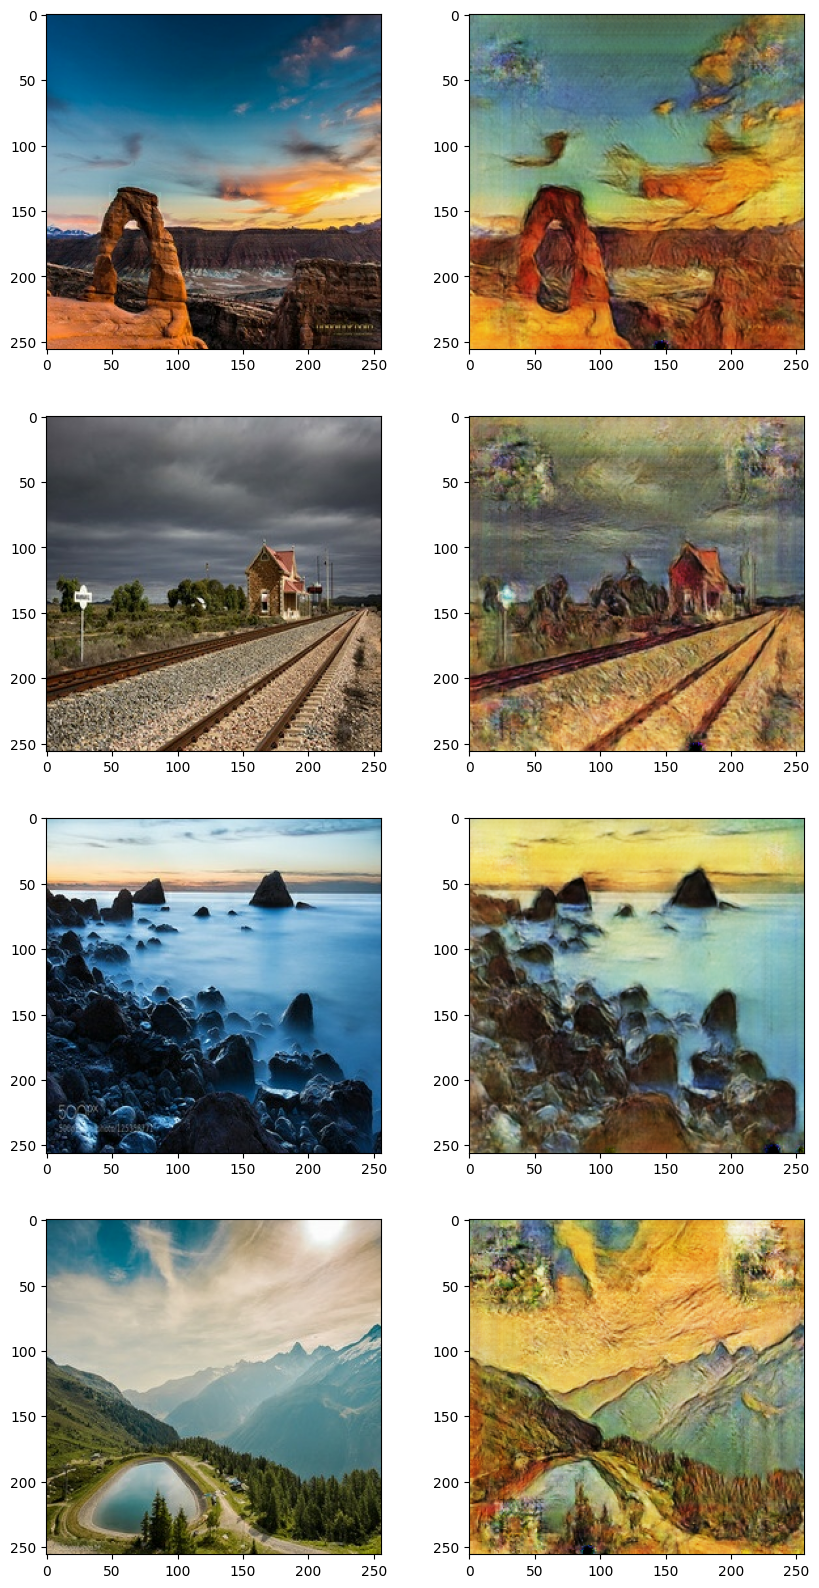

In [ ]:
generated = model.generatorS(sample[0])

fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(10, 20))
for i in range(BATCH_SIZE):
    axes[i][0].imshow(np.squeeze(tf.cast(sample[0][i]*127.5+127.5, dtype=tf.uint8)))
    axes[i][1].imshow(np.squeeze(tf.cast(generated[i]*127.5+127.5, dtype=tf.uint8)))

### Saving the Model

In [ ]:
model.save('CycleGAN.h5')